In [1]:
from os.path import expandvars
    
import numpy as np
from astropy import units as u

import matplotlib.pyplot as plt
%matplotlib inline


# Read first event

In [2]:
from ctapipe.io.hessio import hessio_event_source

filename = expandvars("$HOME/Data/cta/ASTRI9/gamma/run1002.simtel.gz")

source = hessio_event_source(filename,
                             allowed_tels=[34],
                             max_events=10)

# just want one event so break immediately
for event in source: break
print(event.mc.energy)

1.0032621622085571 TeV


# Display photo-electron image on first camera

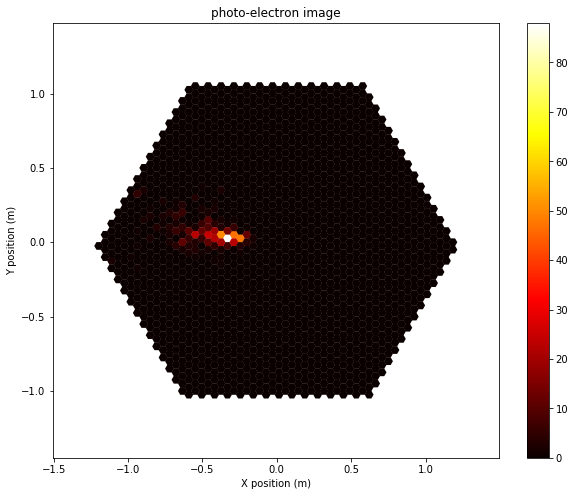

In [3]:
from ctapipe.instrument.camera import CameraGeometry
from ctapipe.visualization import CameraDisplay

for tel_id in event.dl0.tels_with_data: break

cam_geom = CameraGeometry.guess(event.inst.pixel_pos[tel_id][0],
                                event.inst.pixel_pos[tel_id][1],
                                event.inst.optical_foclen[tel_id])


pmt_signal_p = event.mc.tel[tel_id].photo_electron_image

plt.figure(figsize=(10,8))
disp1 = CameraDisplay(cam_geom,
                      image=pmt_signal_p)
disp1.cmap = plt.cm.hot
disp1.add_colorbar()
plt.title("photo-electron image")

# Calibrate ADC image
need to get from ADC counts to an estimate for photo-electrons

In [4]:
# calibrate the event
from ctapipe.calib import CameraCalibrator
calib = CameraCalibrator(None, None)

# CameraCalibrator calibrates all telescopes in the event at once
calib.calibrate(event)

# some cameras have more than one gain channel,
# need to pick one with the [0] at the end
pmt_signal = event.dl1.tel[tel_id].image[0]

## display again

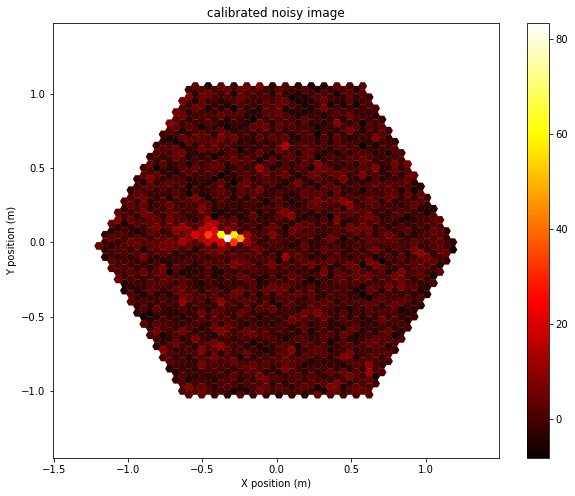

In [5]:
plt.figure(figsize=(10,8))
disp2 = CameraDisplay(cam_geom,
                      image=pmt_signal)
disp2.cmap = plt.cm.hot
disp2.add_colorbar()
plt.title("calibrated noisy image")

# tailcut cleaning
two level thresholding

In [6]:
from ctapipe.image.cleaning import tailcuts_clean

# make a copy first
cleaned_image = pmt_signal[:]

# create a mask of pixels we want to keep
mask = tailcuts_clean(cam_geom, pmt_signal,
                      picture_thresh=15,
                      boundary_thresh=5)

# set all rejected pixels to zero
cleaned_image[~mask] = 0

# Hillas Parametrisation
first few moments of the distribution of pixel intensity  
(orientation, mean position, length, width, skewness, kurtosis, ...)

In [7]:
from ctapipe.image.hillas import hillas_parameters_4 as hillas_parameters

hillas_moments = hillas_parameters(cam_geom.pix_x,
                                   cam_geom.pix_y,
                                   pmt_signal)

# Display cleaned image
and overlay hillas parameters

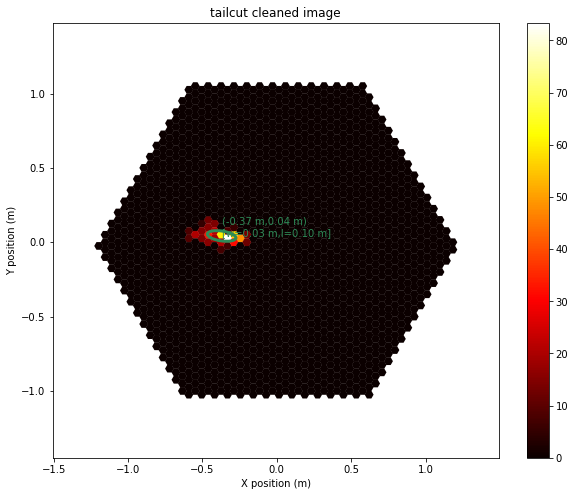

In [8]:
plt.figure(figsize=(10,8))
disp3 = CameraDisplay(cam_geom,
                      image=pmt_signal)
disp3.cmap = plt.cm.hot
disp3.add_colorbar()
disp3.overlay_moments(hillas_moments, color='seagreen', linewidth=3)
plt.title("tailcut cleaned image")